# Harmonic oscillators

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ June 7, 2023

This notebook tests how to do the Moshinsky transformation of two Woods-Saxon wavefunctions into relative and C.o.M. wavefunctions.

_Last update:_ June 7, 2023

In [1]:
# Python imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import factorial, factorial2, genlaguerre, sph_harm

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters
from single_particle_states import SingleParticleState, WoodsSaxon

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Harmonic oscillator wavefunctions in coordinate space

$$
\psi_{nlm}(\mathbf{r}) = R_{nl}(r) Y_{lm}(\hat{r})
$$

$$
R_{nl}(r) = \sqrt{\frac{\nu^{3/2} 2^{n+l+2} n!}{\pi^{1/2} (2l+2n+1)!!}}
(\nu r^2)^{l/2} L_n^{l+1/2}(\nu r^2) e^{-\nu r^2/2}
$$

In [4]:
class HarmonicOscillator:
    
    # Mass of the nucleon in MeV
    m = (939.565 + 938.272) / 2
    
    # \hbar c in Mev fm
    hbarc = 197.326  
    
    def __init__(self, A):
        
        # Set instance attributes
        self.hbar_omega = 45 / (A ** (1/3)) - 25 / (A ** (2/3))  # MeV
        self.nu = self.hbar_omega * self.m / self.hbarc ** 2  # fm^-2
    
    def psi(self, r, theta, phi, n, l, m):
        """Spherical harmonic oscillator wavefunction in coordinate space."""
    
        return self.R_nl(r, l, n) * sph_harm(m, l, phi, theta)
    
    def radial_normalization_factor(self, n, l):
        """Normalization of R_nl(r). Units are fm^-3/2."""
    
        numerator = self.nu ** (3/2) * 2 ** (n+l+2) * factorial(n)
        denominator = np.sqrt(np.pi) * factorial2(2*n+2*l+1)
    
        return np.sqrt(numerator / denominator)
    
    def R_nl(self, r, n, l):
        """Radial wavefunction of the spherical harmonic oscillator in
        coordinate space.
        """
    
        factor = self.radial_normalization_factor(n, l)
        laguerre_polynomial = genlaguerre(n, l+1/2)
        xi = self.nu * r ** 2  # Unitless
    
        return factor * xi ** (l/2) * laguerre_polynomial(xi) * np.exp(-xi/2)

In [5]:
r_array = np.arange(0.0, 10.0, 0.1)
dr = r_array[1] - r_array[0]

In [6]:
# Test normalization of harmonic oscillator wavefunctions given A=16
A = 16
harmonic_oscillator = HarmonicOscillator(A)

# Normalization of R_nl(r) for n, l = 0, 0
n, l = 0, 0
R_nl_array = harmonic_oscillator.R_nl(r_array, n, l)
norm = np.sum(dr * r_array ** 2 * np.abs(R_nl_array) ** 2)
print(f"n={n}, l={l}, normalization={norm}")

# Normalization of R_nl(r) for n, l = 1, 1
n, l = 3, 1
R_nl_array = harmonic_oscillator.R_nl(r_array, n, l)
norm = np.sum(dr * r_array ** 2 * np.abs(R_nl_array) ** 2)
print(f"n={n}, l={l}, normalization={norm}")

# Normalization of R_nl(r) for n, l = 0, 2
n, l = 0, 2
R_nl_array = harmonic_oscillator.R_nl(r_array, n, l)
norm = np.sum(dr * r_array ** 2 * np.abs(R_nl_array) ** 2)
print(f"n={n}, l={l}, normalization={norm}")

n=0, l=0, normalization=0.999999999999976
n=3, l=1, normalization=0.9999983934221249
n=0, l=2, normalization=0.9999999999924951


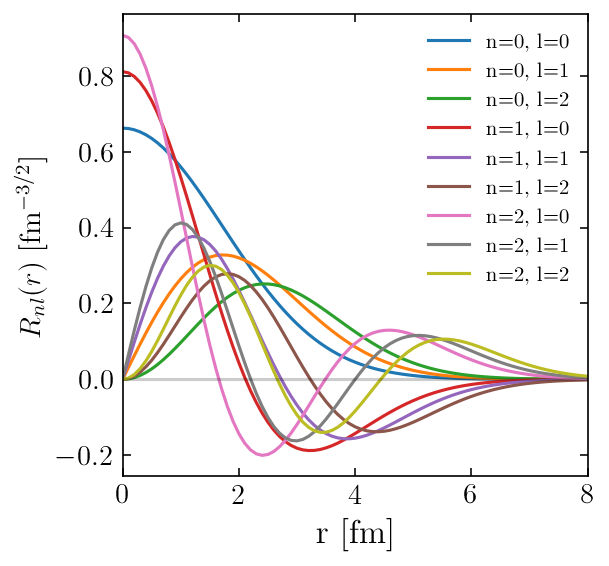

In [7]:
# Plot radial part
# Initialize figure

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))

for n in range(3):
    for l in range(3):
        
        R_nl_array = harmonic_oscillator.R_nl(r_array, n, l)
        
        ax.plot(r_array, R_nl_array, label=f"n={n}, l={l}")
        
ax.axhline(y=0.0, alpha=0.2, color='black')
        
# Set axes limits
ax.set_xlim((0, 8))
# ax.set_ylim(())

# Set axes labels
ax.set_xlabel("r [fm]", fontsize=16)
ax.set_ylabel(r"$R_{nl}(r)$ [fm$^{-3/2}$]")

# Set legend
ax.legend(loc='upper right', fontsize=10, frameon=False)

plt.show()

## Expansion of Woods-Saxon $\frac{u_{nlj}(r)}{r}$ in terms of harmonic oscillator wavefunctions

$$
\frac{u_{n l j m_t}(r)}{r} = \sum_{n'} C_{n' l j m_t} R_{n'l}(r)
$$

$$
C_{n l j m_t} = \int_0^\infty dr r \, u_{n l j  m_t}(r) R^*_{n l}(r)
$$

In [8]:
class SingleParticleBasis:
    
    def __init__(self, woods_saxon, harmonic_oscillator):
        
        self.woods_saxon = woods_saxon
        self.harmonic_oscillator = harmonic_oscillator
    
    def R_nlj(self, r, n, l, j, m_t, n_max=4):
        """Expansion of Woods-Saxon radial wavefunction u(r)/r."""
        
        R_array = np.zeros_like(r)
        
        # To-do: Vectorize this w.r.t. n'
        for nprime in range(0, n_max+1):
        
            # Overlap coefficient
            C = self.overlap(nprime, n, l, j, m_t)
            
            # TESTING
            print(f"n'={nprime}, C={C}")
        
            # Radial harmonic oscillator wavefunctions
            R_npl = self.harmonic_oscillator.R_nl(r, nprime, l)
            
            R_array += C * R_npl
            
        return R_array
    
    def overlap(self, nprime, n, l, j, m_t):
        """Overlap coefficient between the Woods-Saxon and spherical harmonic
        oscillator radial wavefunctions.
        """
        
        dr = self.woods_saxon.dr
        r_array = self.woods_saxon.r_array
        sp_state = SingleParticleState(n, l, j, j, m_t)
        u_nlj_array = self.woods_saxon.get_wf_rspace(sp_state)
        
        R_nl_array = self.harmonic_oscillator.R_nl(r_array, nprime, l)
        
        C = dr * np.sum(r_array * u_nlj_array * np.conj(R_nl_array))
        
        return C

In [9]:
# Test normalization of harmonic oscillator wavefunctions given A=16
A = 16
woods_saxon = WoodsSaxon('O16', 8, 8, run_woods_saxon=False)
harmonic_oscillator = HarmonicOscillator(A)
spb = SingleParticleBasis(woods_saxon, harmonic_oscillator)

# n = 1, l = 1, j = 1/2
radial_wf_array = spb.R_nlj(r_array, 1, 1, 1/2, 1/2)

n'=0, C=6.56003392725984
n'=1, C=-5.2836903967742845
n'=2, C=6.381961565851715
n'=3, C=-6.404217069499959
n'=4, C=6.994299899462187
